# this notebooks shows an example of generating building blocks from a list of smiles

In [1]:
import itertools
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem
import pandas as pd
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import os
os.chdir('/rds/general/user/ma11115/home/STK_Search/STK_search')

In [2]:
# helper function to define building blocks from fragments
def fragment_from_smiles(smile):
    mol2=Chem.MolFromSmiles(smile)
    mol2=Chem.AddHs(mol2)
    if rdMolDescriptors.CalcNumAromaticRings(mol2)>6:
        return [],[],[]
    if mol2.GetNumAtoms()>40:
        return [],[],[]
    potential_connection=[]
    for x in mol2.GetAtoms():
        #print(x.GetIdx(), x.GetHybridization())
        if x.GetAtomicNum() == 35 or x.GetAtomicNum() == 34 or x.GetAtomicNum() == 17:
            return [],[],[]
        if x.GetAtomicNum() == 6 and x.GetHybridization().name == 'SP2':
            for atom in x.GetNeighbors():
                if atom.GetAtomicNum() == 1:
                    potential_connection.append(atom.GetIdx())#atom.SetAtomicNum(35)
    mol_list = []
    mol_list_smiles=[]
    potential_connection=list(set(potential_connection))
    #print(potential_connection)
    #print(len(set(itertools.combinations(potential_connection, 2))))
    for atom1,atom2 in set(itertools.combinations(potential_connection, 2)):
        mol_trans=Chem.Mol(mol2)
        
        pass_case=False
        Neighbour_atom1 = mol_trans.GetAtoms()[atom1].GetNeighbors()
        Neighbour_atom2 = mol_trans.GetAtoms()[atom2].GetNeighbors()
        for atom1_N in Neighbour_atom1:
            for atom2_N in Neighbour_atom2:
                if atom1_N.GetIdx() == atom2_N.GetIdx():
                    pass_case=True
                    break
                if atom1_N.GetIdx() in [x.GetIdx() for x in atom2_N.GetNeighbors()]:
                    pass_case=True
                    break
                if len(set([x.GetIdx() for x in atom1_N.GetNeighbors()])\
                    .intersection(set([x.GetIdx() for x in atom2_N.GetNeighbors()])))>0:
                  #  print(len(set([x.GetIdx() for x in atom1_N.GetNeighbors()])\
                  #.intersection(set([x.GetIdx() for x in atom2_N.GetNeighbors()])))>0)
                    pass_case=True
                    break
        if pass_case:
            continue
        mol_trans.GetAtoms()[atom1].SetAtomicNum(35)
        mol_trans.GetAtoms()[atom2].SetAtomicNum(35)
        mol_list.append(mol_trans)
        mol_list_smiles.append(Chem.MolToSmiles(mol_trans))
    return mol_list,mol_list_smiles, [smile]

In [4]:
# load a dataframe with a list of fragments as smiles
df_unit_polymer=pd.read_csv('data/input/classification_unit_A_or_D.csv')
df_unit_polymer.head()

,Unnamed: 0,fragment_number,smi_filename,smiles,sTDDFTxtb_HOMO,B3LYP_HOMO,A_or_D
0,0,0,0_TL.smi,C(=C1C(=O)c2cc(F)c(F)cc2C1=C(C#N)C#N),-16.456,-7.491072,A
1,1,1,1_TL.smi,C(=C1C(=O)c2ccccc2C1=C(C#N)C#N),-16.284,-7.364308,A
2,2,10,10_TL.smi,C(=C1C(=O)N(CC)C(=S)N(CC)C1=O),-14.764,-6.244068,D
3,3,100,100_C.smi,c1cc2C(CC)(CC)c3c(-c2cc1)ccc(c3),-15.072,-6.471064,D
4,4,101,101_C.smi,c1cc2C(=O)NC(=O)c3cc(cc(c1)c23),-15.743,-6.965591,A


737
453
161


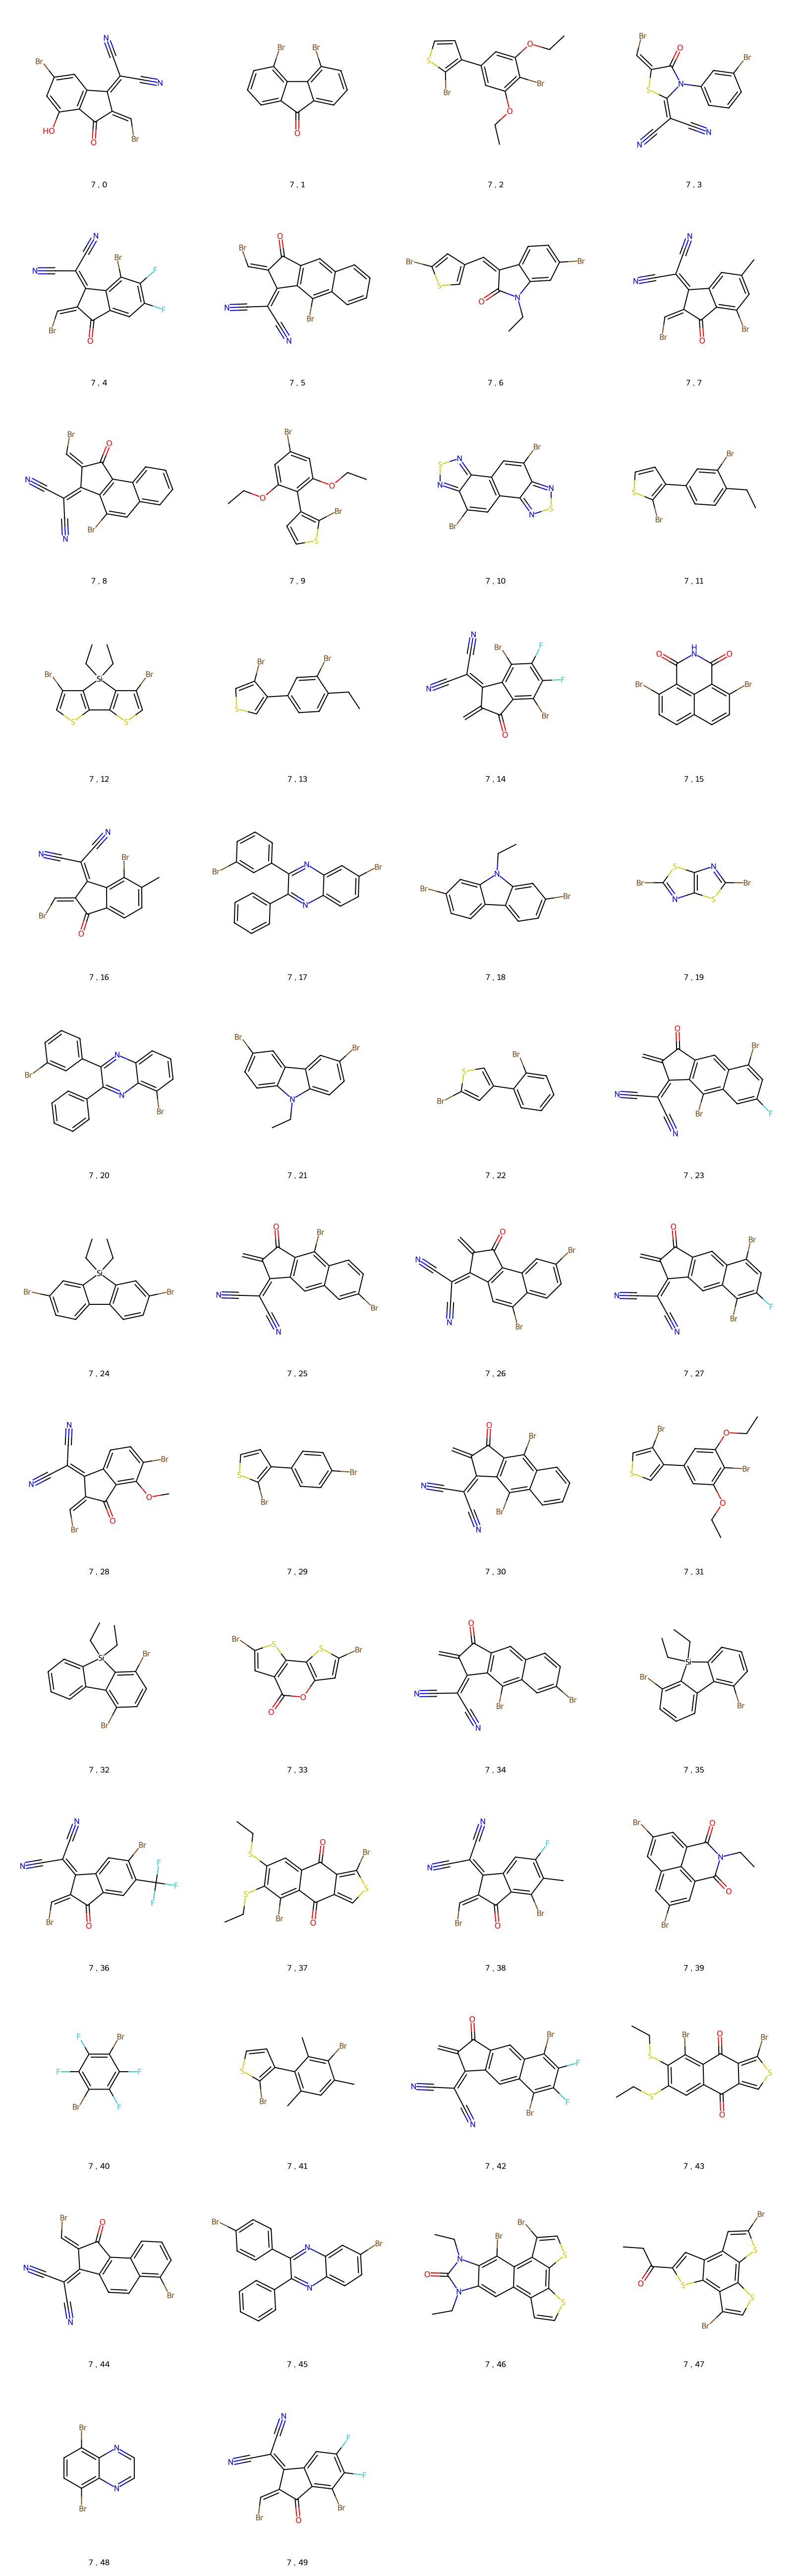

In [5]:
mol_list_smiles_all=[]
mol_list_all=[]
org_smiles=[]

for count,smiles in enumerate(df_unit_polymer['smiles']):
    mol=Chem.MolFromSmiles(smiles)
    if mol.GetNumAtoms()<30:
        mol_list,mol_list_smiles,smile=fragment_from_smiles(smiles)
        mol_list_smiles_all+=mol_list_smiles
        mol_list_all+=mol_list
        org_smiles+=smile

    #if count>12:
     #   break
print(len(mol_list_smiles_all))
mol_list_all = [Chem.MolFromSmiles(smile) for smile in set(mol_list_smiles_all)]
mol_list_all_org = [Chem.MolFromSmiles(smile) for smile in set(org_smiles)]
print(len(set(mol_list_smiles_all)))
print(len(set(org_smiles)))
img=Draw.MolsToGridImage(mol_list_all[:50],molsPerRow=4,subImgSize=(400,400),returnPNG=False,legends=[f"7 , {index}" for index, x in enumerate(mol_list_all)])    
img


In [7]:
mol_list_smiles_all

['[H]C(Br)=C1C(=O)c2c(Br)c(F)c(F)c([H])c2C1=C(C#N)C#N',
 '[H]C(Br)=C1C(=O)c2c(Br)c(F)c(F)c([H])c2C1=C(C#N)C#N',
 '[H]C(Br)=C1C(=O)c2c([H])c(F)c(F)c(Br)c2C1=C(C#N)C#N',
 '[H]C(Br)=C1C(=O)c2c([H])c(F)c(F)c(Br)c2C1=C(C#N)C#N',
 '[H]C([H])=C1C(=O)c2c(Br)c(F)c(F)c(Br)c2C1=C(C#N)C#N',
 '[H]C(Br)=C1C(=O)c2c([H])c([H])c(Br)c([H])c2C1=C(C#N)C#N',
 '[H]C(Br)=C1C(=O)c2c([H])c([H])c([H])c(Br)c2C1=C(C#N)C#N',
 '[H]C(Br)=C1C(=O)c2c([H])c([H])c(Br)c([H])c2C1=C(C#N)C#N',
 '[H]C(Br)=C1C(=O)c2c([H])c(Br)c([H])c([H])c2C1=C(C#N)C#N',
 '[H]C(Br)=C1C(=O)c2c([H])c(Br)c([H])c([H])c2C1=C(C#N)C#N',
 '[H]C(Br)=C1C(=O)c2c([H])c([H])c([H])c(Br)c2C1=C(C#N)C#N',
 '[H]C(Br)=C1C(=O)c2c(Br)c([H])c([H])c([H])c2C1=C(C#N)C#N',
 '[H]C([H])=C1C(=O)c2c(Br)c([H])c([H])c(Br)c2C1=C(C#N)C#N',
 '[H]C(Br)=C1C(=O)c2c(Br)c([H])c([H])c([H])c2C1=C(C#N)C#N',
 '[H]c1c([H])c([H])c2c(c1[H])-c1c(Br)c([H])c([H])c(Br)c1C2(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H]',
 '[H]c1c([H])c([H])c2c(c1[H])-c1c(Br)c([H])c([H])c(Br)c1C2(C([H])([

In [6]:
# save a list of smiles into a file
with open('data/input/fragementclean_1005.txt', 'w') as f:
    for item in set(mol_list_smiles_all):
        f.write("%s\n" % item)

In [9]:
import stk
def load_precursors(smile):
    """ Function to generate stk building block from smiles"""
    precursor = stk.BuildingBlock(
            smile, functional_groups=[
                stk.BromoFactory()])

    return precursor


In [17]:
from stk_search import Objective_function
calculator = Calculate_Precursor()
ES1 = calculator.evaluate_element(mol_list_smiles_all[0])

TypeError: Calculate_Precursor.load_precursors() takes 1 positional argument but 2 were given

In [15]:
import os
import re

import numpy as np
import pandas as pd
import pymongo
import stk
import stko

from stk_search.Calculators.STDA_calculator import sTDA_XTB
from stk_search.Calculators.XTBcalculator import XTBEnergy2

def get_inchi_key(molecule):
    return stk.InchiKey().get_key(molecule)

class Calculate_Precursor():
    def __init__(self):
        self.client = "mongodb://ch-atarzia.ch.ic.ac.uk/"
        self.db_mol = "stk_mohammed_new"
        self.xtb_path = (
            "/rds/general/user/ma11115/home/anaconda3/envs/ML/bin/xtb"
        )
        self.STDA_bin_path = (
            "/rds/general/user/ma11115/home/bin/stda_files/xtb4stda/"
        )
        self.Db_folder = (
            "/rds/general/ephemeral/user/ma11115/ephemeral/BO_precursor"
        )
        os.makedirs(self.Db_folder, exist_ok=True)
        # print(self.collection_name)
        self.host_IP = "cx1"
        self.collection_name = "Precursors"

    def load_precursors(self, smile):
        """ Function to generate stk building block from smiles"""
        precursor = stk.BuildingBlock(
                smile, functional_groups=[
                    stk.BromoFactory()])

        return precursor

    def evaluate_element(self, smile):
        # initialise the database
        client = pymongo.MongoClient(self.client)
        db_mol = stk.MoleculeMongoDb(
            client,
            database=self.db_mol,
        )
        # define the path to xtb and stda
        xtb_path = self.xtb_path
        STDA_bin_path = self.STDA_bin_path
        # define the output directories
        Db_folder = self.Db_folder
        output_dir_ipea = os.path.join(
            Db_folder, "Database", "xtb_calculations"
        )
        xtb_opt_output_dir = os.path.join(
            Db_folder, "Database", "xtb_opt_output_dir"
        )
        output_dir_stda = os.path.join(
            Db_folder, "Database", "stda_output_dir"
        )
        os.makedirs(output_dir_ipea, exist_ok=True)
        os.makedirs(xtb_opt_output_dir, exist_ok=True)
        os.makedirs(output_dir_stda, exist_ok=True)
        # define the database and collection name
        collection_name = self.collection_name
        # print(collection_name)
        precursor = self.load_precursors(smile)
        precursor = self.run_xtb_opt(
            precursor,
            xtb_path,
            xtb_opt_output_dir,
            database=self.db_mol,
            collection=collection_name + "_opt",
            client=client,
        )
        Inchikey = stk.InchiKey().get_key(precursor)

        IP = self.run_xtb_ipea(
            precursor,
            xtb_path,
            output_dir_ipea,
            database=self.db_mol,
            target="ionisation potential (eV)",
            collection=collection_name + "_IPEA",
            client=client,
        )
        Es1 = self.run_stda(
            precursor,
            STDA_bin_path,
            output_dir_stda,
            property="Excited state energy (eV)",
            state=0,
            database=self.db_mol,
            collection=collection_name + "_Stda",
            client=client,
        )
        return Es1, Inchikey



    def run_xtb_opt(
        self,
        polymer,
        xtb_path,
        xtb_opt_output_dir,
        database="stk_mohammed_BO",
        collection="test",
        client=None,
    ):
        def save_xtb_opt_calculation(
            polymer, xtb_opt_output_dir, collection=None, InchiKey_initial=None
        ):
            def get_property_value(data, property_name):
                for line in data:
                    if property_name in line:
                        if property_name == "cpu-time":
                            property_value = (
                                re.findall(r"[-+]?(?:\d*\.*\d+)", line)[-3]
                                + " h "
                                + re.findall(r"[-+]?(?:\d*\.*\d+)", line)[-2]
                                + " min "
                                + re.findall(r"[-+]?(?:\d*\.*\d+)", line)[-1]
                                + " s "
                            )
                            return property_value
                        property_value = float(
                            re.findall(r"[-+]?(?:\d*\.*\d+)", line)[-1]
                        )  # float(words[3]) #
                        return property_value

            polymer_xtb_opt_calc = {
                "InChIKey": stk.InchiKey().get_key(polymer),
                "cal_folder": os.path.join(
                    xtb_opt_output_dir, stk.InchiKey().get_key(polymer)
                ),
                "Host IP": self.host_IP,
                "InChIKey_initial": InchiKey_initial,
            }
            outfile = open(
                os.path.join(
                    polymer_xtb_opt_calc["cal_folder"], "optimization_1.output"
                ),
                "r",
                encoding="utf8",
            )
            data = outfile.readlines()
            outfile.close()
            polymer_xtb_opt_calc["cpu time"] = get_property_value(
                data, "cpu-time"
            )
            polymer_xtb_opt_calc["total energy (au)"] = get_property_value(
                data, "TOTAL ENERGY"
            )
            polymer_xtb_opt_calc["HOMO-LUMO GAP (eV)"] = get_property_value(
                data, "HOMO-LUMO GAP"
            )
            collection.update_many(
                filter={"InChIKey": get_inchi_key(polymer)},
                update={"$set": polymer_xtb_opt_calc},
                upsert=True,
            )

        collection = client[database][collection]
        if (
            collection.find_one({"InChIKey": get_inchi_key(polymer)})
            is not None
        ):
            # print("already calculated", end="\r")

            db_polymer = stk.MoleculeMongoDb(
                client,
                database=database,
            )
            polymer = db_polymer.get({"InChIKey": get_inchi_key(polymer)})
            # print(get_inchi_key(polymer), ' opt geom already calculated')
            return polymer
        if (
            collection.find_one({"InChIKey_initial": get_inchi_key(polymer)})
            is not None
        ):
            # print("already calculated", end="\r")
            db_polymer = stk.MoleculeMongoDb(
                client,
                database=database,
            )
            data = collection.find_one(
                {"InChIKey_initial": get_inchi_key(polymer)}
            )
            # print(get_inchi_key(polymer), ' opt geom already calculated with old geom')

            polymer = db_polymer.get({"InChIKey": data["InChIKey"]})
            return polymer
        output_dir = os.path.join(xtb_opt_output_dir, get_inchi_key(polymer))
        InchiKey_initial = get_inchi_key(polymer)
        xtb = stko.OptimizerSequence(
            stko.ETKDG(),
            stko.XTB(
                xtb_path=xtb_path,
                output_dir=output_dir,
                unlimited_memory=False,
                num_cores=25,
            ),
        )
        polymer = xtb.optimize(polymer)
        new_output_dir = os.path.join(
            xtb_opt_output_dir, get_inchi_key(polymer)
        )
        os.rename(output_dir, new_output_dir)
        save_xtb_opt_calculation(
            polymer,
            xtb_opt_output_dir,
            collection=collection,
            InchiKey_initial=InchiKey_initial,
        )
        db_polymer = stk.MoleculeMongoDb(
            client,
            database=database,
        )
        db_polymer.put(polymer)
        return polymer

    def run_xtb_ipea(
        self,
        polymer,
        xtb_path,
        xtb_opt_output_dir,
        database="stk_mohammed_BO",
        collection="testIPEA",
        target="ionisation potential (eV)",
        client=None,
    ):
        collection = client[database][collection]
        XTB_results = collection.find_one({"InChIKey": get_inchi_key(polymer)})
        if XTB_results is not None:
            # print("already calculated", end="\r")
            # print(get_inchi_key(polymer), ' ipea geom already calculated')
            return XTB_results[target]
        xtb = XTBEnergy2(
            xtb_path=xtb_path,
            output_dir=os.path.join(
                xtb_opt_output_dir, get_inchi_key(polymer)
            ),
            unlimited_memory=False,
            calculate_ip_and_ea=True,
            num_cores=25,
        )
        xtb_results = xtb.get_results(polymer)
        XTB_results = {
            "total energy (au)": xtb_results.get_total_energy()[0],
            "homo lumo_gap (eV)": xtb_results.get_homo_lumo_gap()[0],
            "electron affinity (eV)": xtb_results.get_electron_affinity()[0],
            "ionisation potential (eV)": xtb_results.get_ionisation_potential()[
                0
            ],
            "InChIKey": get_inchi_key(polymer),
            "cal_folder": os.path.join(
                xtb_opt_output_dir, get_inchi_key(polymer)
            ),
            "Host IP": self.host_IP,
        }
        collection.update_many(
            filter={"InChIKey": get_inchi_key(polymer)},
            update={"$set": XTB_results},
            upsert=True,
        )
        return XTB_results[target]

    def run_stda(
        self,
        polymer,
        STDA_bin_path,
        output_dir,
        property="Excited state energy (eV)",
        state=1,
        database="stk_mohammed",
        collection="test",
        client=None,
    ):
        collection = client[database][collection]
        STDA_results = collection.find_one(
            {"InChIKey": get_inchi_key(polymer)}
        )
        if STDA_results is not None:
            # print(get_inchi_key(polymer), ' stda geom already calculated')
            # print(STDA_results[property][state])
            return STDA_results[property][state]
        stda = sTDA_XTB(
            STDA_bin_path=STDA_bin_path,
            Num_threads=25,
            output_dir=os.path.join(output_dir, get_inchi_key(polymer)),
        )
        Excited_state_energy, Excited_state_osc = stda.get_results(polymer)
        STDA_results = {
            "Excited state energy (eV)": Excited_state_energy,
            "Excited state oscillator strength": Excited_state_osc,
            "InChIKey": get_inchi_key(polymer),
            "cal_folder": os.path.join(output_dir, get_inchi_key(polymer)),
            "Host IP": self.host_IP,
        }
        collection.update_many(
            filter={"InChIKey": get_inchi_key(polymer)},
            update={"$set": STDA_results},
            upsert=True,
        )
        return STDA_results[property][state]


In [ ]:
from Extract_data_DB import get_OPt_properties_database,get_vipea_properties_database,get_sTDA_XTB_properties_database
import pandas as pd
from rdkit.Chem import rdDetermineBonds

def get_results_df(precursors):
    client = pymongo.MongoClient(
        'mongodb://129.31.66.201/')
    db = stk.MoleculeMongoDb(client, database='stk_mohammed_new',)
    list_mol_dict = []
    key_maker=stk.InchiKey()
    for polymer in precursors:
            mol_db=Run_XTB.run_XTB_vipea(polymer, key_maker, db, opt=True, dbtype='_molecules')
            mol_db=Run_XTB.run_sTDA_XTB(polymer, key_maker, db, opt=True, dbtype='_molecules')
            properties = get_OPt_properties_database(mol_db)
            if properties is not None:
                HOMO, LUMO, HOMO_LUMO_GAP = properties
                mol_dict = {'InChIKey': mol_db['InChIKey'],
                            # mol.GetNumAtoms(),
                            'Atom_num': len(mol_db['a']),
                            # mol.GetNumAtoms(),
                            'HOMO (eV)': HOMO,
                            'LUMO (eV)': LUMO,
                            'HOMO_LUMO_GAP (eV)': HOMO_LUMO_GAP}

            properties_vipea = get_vipea_properties_database(mol_db, db)
            if properties_vipea is not None:
                IP_eV, EA_eV, total_energy_eV = properties_vipea
                mol_dict['IP (eV)'] = IP_eV
                mol_dict['EA (eV)'] = EA_eV
                mol_dict['total energy (eV) vipea'] = total_energy_eV
            properties_exci = get_sTDA_XTB_properties_database(mol_db, db)
            if properties_exci is not None:
                First_Excited_state_energy,   First_Excited_state_osc = properties_exci
                mol_dict['First excited state Energy (eV)'] = First_Excited_state_energy
                mol_dict['First excited osc'] = First_Excited_state_osc
            mol_dict['mol_opt_2']=Chem.MolFromMolFile(mol_db['OPTXTBFolder']+mol_db['InChIKey'].replace('-','_')+'/xtbtopo.mol', removeHs=False)
            if 'mol_dict' in locals():
                list_mol_dict.append(mol_dict)
    df = pd.DataFrame.from_records(list_mol_dict)
    df.to_csv('CSV_records/' +
              f"precursor_df.csv")

    def Inch_to_mol(InChIKey, xyz='OPTXTBxyz'):
        try:
            filename = db._molecules.find_one(
                {stk.InchiKey().get_key_name(): InChIKey})[xyz]
            mol = Chem.Mol(Chem.MolFromXYZFile(filename))
            rdDetermineBonds.DetermineConnectivity(mol, charge=0)
            
            return mol
        except Exception as e: 
            print(e)
            print(f'could not get mol {xyz} for  {InChIKey}')
            return 'error'
    df['mol_opt'] = df['InChIKey'].apply(
        lambda x: Inch_to_mol(x, xyz='OPTXTBxyz'))
    df['mol_prel'] = df['InChIKey'].apply(
        lambda x: Inch_to_mol(x, xyz='RDkitxyz'))
    df.to_pickle('mol_records/' +
                 f"precursor.pkl")
    return df